In [2]:
# Run this notebook first to analyse the experimental video
# The code needs to be run 4 times to analyse each of the 4 views.
# Instead of running this notebook 4 times, it is advisable to make
# 4 copies of this notebook, one for each view.

import cv2
from matplotlib import pyplot as plt
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import csv
import os
import pathlib
import pickle

# load custom modules
from image_proc_lib.file_util import *
from image_proc_lib.cv_util import *
from image_proc_lib.point_selector import *
from image_proc_lib.image_proc import *
from image_proc_lib.image_analyser2 import *

In [4]:
# Experimental Information.
# need to provide relevant information of the video file
# frame rate
fps = 25
# video file name, the video file needs to be placed in the upper directory
# The code is technically able to process any video format supported by OpenCV
vid_file_name = "P89.mxf" 
# data_label labels the views. By convention, "0", "45", "90", "135" are used.
data_label = "0"

vid_file_name_full = get_from_upper_dir(vid_file_name)
# the video time at which the background frame is taken
background_frame_time = 24 # s
# the video time at which the processing starts
start_time = 26 # s
# the bead radius measured during the experiment
bead_measured_rad = 12.5 # mm
# the radius of the rim of the bead holder (used as a length scale)
bead_holder_top_rad = 17.1/2 # mm

In [23]:
# loads the background frame of the video
cap = VideoManager(vid_file_name_full)
first_frame = cap.retrieve_frame()
background_frame = cap.load_to_time(background_frame_time)
disp_cv_img(background_frame)

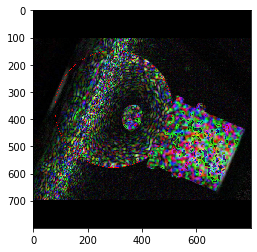

length scale factor: 0.039398097796727996 mm/pixel


In [24]:
# Compute the difference between the background frame and the first frame
# this highlights the region occupied by the bead.
# For this to work, the bead must only be placed in the tank after the video
# recording has started.
diff_enhanced = np.abs(background_frame.astype(int) - \
                       first_frame.astype(int))*2
diff_enhanced = diff_enhanced.astype(np.uint8)

bs = BeadRegionSelector()
# the bead selector is initialized
# first, select the region occupied by the view to be analysed
# next select the points on the perimeter of the bead for a circle fitting
bs.initialize(diff_enhanced)
# displays the region of interest with the bead position labelled.
disp_cv_img(bs.label_frame_roi(diff_enhanced))

# calculate a length scale factor based on the radius of the bead
length_scale_factor = bead_measured_rad / bs.bead_rad #  "*disp_ratio" is missing in previous versions!
print("length scale factor: " + str(length_scale_factor) + " mm/pixel")

In [25]:
bead_img = get_roi(background_frame, bs.bead_region)

selector = PointSelector(bead_img, "select points on the rim of the beam holer")
# select the two extreme points on the rim of the bead holder
selector.run()
pt_list = selector.get_pt_list()
if len(pt_list) != 2:
    print("Error, only two points should be selected!")

# calculate another length scale based on the size of the bead holder
length_scale_factor_2 = bead_holder_top_rad * 2/ abs(np.linalg.norm(pt_list[0] - pt_list[1]))
print("length scale factor 2: " + str(length_scale_factor_2) + " mm/pixel")

length scale factor 2: 0.040728171296703926 mm/pixel


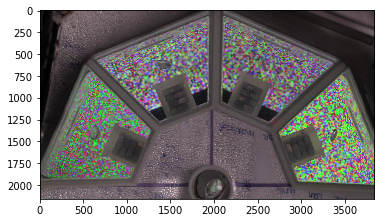

In [26]:
# load the video to start time
start_frame = cap.load_to_time(start_time)
disp_cv_img(start_frame)

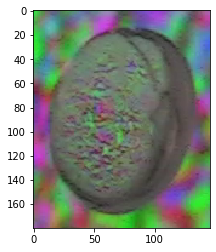

In [27]:
# select the region occupied by the crack of interest in the view analysed
roi = manual_select_roi(start_frame, 0.3)
start_frame_cropped = get_roi(start_frame, roi)
disp_cv_img(start_frame_cropped)

In [28]:
# initialize the image analyser
image_analyser = ImageAnalyser(cap)
image_analyser.clear()
# enable the use of a mask further narrow the region of interest
image_analyser.use_mask = True

In [29]:
# start the image analyser.
# By default, the image analyser will be in single mode, that is, the
# image analyser only moves to the next frame when a key on the keyboard 
# is pressed. Press "c" to enter continous mode, where the image analyser
# moves to the next frame without waiting for keyboard input.
# Press any key other than "c" to exit continous mode.
# Press "q" to end image analysis
image_analyser.run(roi, background_frame)

start continuous mode     


In [18]:
# If the image analyser crashes for any reason, run this to close the 
# open cv window.
cv2.destroyAllWindows()

In [30]:
# graph the data
# max_len_list is the list of crack diameters (in pixels)
max_len_list = image_analyser.max_len_list
plt.plot(np.array(max_len_list)[:,1])
plt.show()

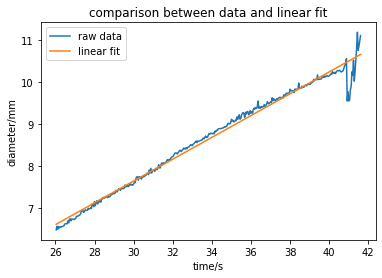

In [31]:
# More data visualization

# estimate the data linearly
time_list = np.array(max_len_list)[:,0]/fps
diameter_list = np.array(max_len_list)[:,1] * length_scale_factor_2
thresh_list = np.array(max_len_list)[:,2]
slope, intercept, r_value, p_value, std_err = stats.linregress(time_list,diameter_list)
linear_list = slope*time_list + intercept
plt.plot(time_list, diameter_list)
plt.plot(time_list, linear_list)
plt.title("comparison between data and linear fit")
plt.xlabel('time/s')
plt.ylabel('diameter/mm')
plt.legend(["raw data", "linear fit"])
plt.show()

# remove any point that has a large deviation
deviation_list = (linear_list - diameter_list) / diameter_list
plt.plot(time_list, deviation_list)
plt.title("deviation from linear fit")
plt.xlabel('time/s')
plt.ylabel('deviation')
plt.show()

time_list_trimmed = []
diameter_list_trimed = []
for i in range(len(time_list)):
    if abs(deviation_list[i]) < 0.15:
        time_list_trimmed.append(time_list[i])
        diameter_list_trimed.append(diameter_list[i])
plt.plot(time_list_trimmed, diameter_list_trimed)
plt.title("trimmed data")
plt.xlabel('time/s')
plt.ylabel('diameter/mm')
plt.show()

In [32]:
# Export processed data
# By default, over-write is not enabled. If a file with the same file name 
# already exists, the code will not over-write it. The code will print out
# a message to alert the user.
# Before running this cell, it is advisable to ensure that "data_label" in
# the second cell has been set correctly.
notebook_name = "continuous_run_dev2"

# make the directory that contains the data
rel_dir_name = "processed data " + data_label
if exist_directory(rel_dir_name):
    print("\"" + rel_dir_name + "\" already exists.")
else:
    os.mkdir(full_path(rel_dir_name))
    print("directory \"" + rel_dir_name + "\" is made")

# export the original R-t data from tracking
full_data = np.array([time_list, diameter_list, thresh_list]).transpose()
export_to_csv(rel_dir_name + "\\" + "full data " + data_label + ".csv", full_data, ["t/s", "diamter/mm", "thresh"])

# export the trimmed R-t data
trimmed_data = np.array([time_list_trimmed, diameter_list_trimed]).transpose()
export_to_csv(rel_dir_name + "\\" + "trimmed data " + data_label + ".csv", trimmed_data, ["t/s", "diamter/mm"])

# export relevant information
f = open_file_w_with_check(rel_dir_name + "\\" + "processing information " + data_label + ".txt")
if not (f is None):
    f.write("# notebook name: " + notebook_name + "\n")
    f.write("fps = " + str(fps) + "\n")
    f.write("vid_file_name = " + str(vid_file_name)+ "\n")
    f.write("start_time = " + str(start_time)+ "\n")
    f.write("bead_measured_rad = " + str(bead_measured_rad) + " # mm" + "\n")
    f.write("bead_holder_top_rad = " + str(bead_holder_top_rad) + " # mm" + "\n")
    f.write("length_scale_factor = " + str(length_scale_factor) + " # mm/pixel, based on bead rad" + "\n")
    f.write("length_scale_factor_2 = " + str(length_scale_factor_2) + " # mm/pixel, based on bead holder top rad" + "\n")
    f.close()

# export frame by frame data
f = open_file_w_with_check(rel_dir_name + "\\" + "frame_descriptor_json_dataa " + data_label + ".txt")
if not (f is None):
    for item in image_analyser.frame_descriptor_list:
        try:
            f.write(str(item) + "\n") # sometimes, this goes wrong
        except:
            f.close() # catch the exception, close the file, and throw the exception again.
            raise 
    f.close()

f = open_file_w_with_check(rel_dir_name + "\\" + "frame_descriptor_pickle_dump " + data_label + ".pickle",
                           mode='wb')
if not (f is None):
    pickle.dump(image_analyser.frame_descriptor_list, f)
    f.close()

directory "processed data 0" is made
